To begin copy this notebook to your own drive:

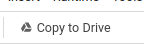


### Submission Instructions:
1. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
2. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and all the cells include their outputs

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [28]:
!pip install datasets
!pip install transformers
!pip install nltk
!pip install evaluate

In [29]:
import nltk
nltk.download('punkt_tab')
## If you're usig older version of nltk, you night need to use this lin instead:
# nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [30]:
# The assignment zip includes 2 files you need to use:
# 'glove.npy' and 'vocab.json'.
# you can upload the directly to this session storage, using the "files" button on the left menu,
# and then the "upload" button on the top of the sidebar. This upload is only valid for each session,
# so if you restart the session you'll neeed to upload the files again

# If you prefer, You can download the files directly to the sessio using these three lines:
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
From (redirected): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn&confirm=t&uuid=cb83c9fa-6541-4f5e-9015-f5c78fac24ef
To: /content/glove.npy
100%|██████████| 480M/480M [00:05<00:00, 91.4MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 71.6MB/s]


'vocab.json'

In [31]:
import numpy as np
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

In [32]:
from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [33]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

In [34]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [35]:
from evaluate import load
metric = load("accuracy")

### If you're using older versions, use:
# metric = dataset.load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [36]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


## SECTION A - DAN implentation

In [37]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, n_layers = 1, hidden_dim = 256, act=nn.ReLU(), word_dropout = 0.0): # YOU ARE ALSO ALLOWED TO ADD PARAMETER TO THE __INIT__
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE

          dims = [self.embeddings.embedding_dim] + [hidden_dim]*n_layers; layers = []
          if n_layers == 0:
            layers = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]
          else:
            for i in range(len(dims)-1):
              layers += [nn.Linear(dims[i],dims[i+1]),act]
            layers.append(nn.Linear(hidden_dim, self.num_labels))

          self.word_dropout = word_dropout
          self.classifier = nn.Sequential(*layers)
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      if self.training:
        mask = torch.bernoulli(torch.ones_like(attention_masks) * (1 - self.word_dropout))
        attention_masks[mask == 0] = 0
        embeddings[mask == 0, :] = 0
      avg = torch.sum(embeddings, dim=1) / torch.sum(attention_masks, dim=1).unsqueeze(-1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

num_epochs = 20
co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=num_epochs , #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  eval_strategy="epoch") # Older version might need 'evaluation_strateg' instead
model = DAN()



trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE
                 TensorBoardCallback
                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [40]:
import wandb
wandb.login()

True

In [ ]:
trainer.train()

{'loss': 0.4907, 'grad_norm': 0.20473261177539825, 'learning_rate': 0.009502551020408163, 'epoch': 1.0}
{'eval_loss': 0.40494656562805176, 'eval_accuracy': 0.81816, 'eval_runtime': 37.5448, 'eval_samples_per_second': 665.871, 'eval_steps_per_second': 83.234, 'epoch': 1.0}
{'loss': 0.4083, 'grad_norm': 0.23996780812740326, 'learning_rate': 0.009002551020408164, 'epoch': 2.0}
{'eval_loss': 0.3901107907295227, 'eval_accuracy': 0.82564, 'eval_runtime': 38.4042, 'eval_samples_per_second': 650.97, 'eval_steps_per_second': 81.371, 'epoch': 2.0}
{'loss': 0.3866, 'grad_norm': 0.3953264057636261, 'learning_rate': 0.008502551020408164, 'epoch': 3.0}
{'eval_loss': 0.38260912895202637, 'eval_accuracy': 0.8306, 'eval_runtime': 39.0347, 'eval_samples_per_second': 640.456, 'eval_steps_per_second': 80.057, 'epoch': 3.0}
{'loss': 0.3856, 'grad_norm': 0.1391506791114807, 'learning_rate': 0.008002551020408163, 'epoch': 4.0}
{'eval_loss': 0.39354926347732544, 'eval_accuracy': 0.82492, 'eval_runtime': 35.23

TrainOutput(global_step=3920, training_loss=0.3704058121661751, metrics={'train_runtime': 829.1475, 'train_samples_per_second': 603.029, 'train_steps_per_second': 4.728, 'train_loss': 0.3704058121661751, 'epoch': 20.0})

In [38]:
import numpy as np
import matplotlib.pyplot as plt

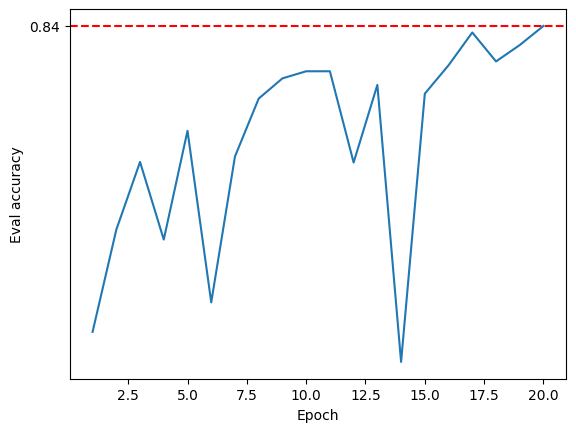

In [ ]:
eval_accuracy = [entry["eval_accuracy"] for entry in trainer.state.log_history if "eval_accuracy" in entry]
max_accuracy = np.max(np.array(eval_accuracy))

plt.figure()
plt.axhline(y=max_accuracy, color='r', linestyle='dashed')
plt.yticks(list(plt.yticks()[0]) + [max_accuracy])
plt.plot(np.arange(1, num_epochs+1), eval_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Eval accuracy')
plt.show()


## SECTION B - Trying drpout

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

co = DataCollatorWithPadding()
num_epochs = 20
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=num_epochs , #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  eval_strategy="epoch") # Older version might need 'evaluation_strateg' instead

drop_rates = np.linspace(0.1,0.5,5)
results_B = []
trainers_B = []
for p in drop_rates:
  model = DAN(word_dropout=p)
  trainers_B.append(Trainer(
                    model=model,
                    data_collator=co,
                    args=training_args,
                    callbacks = [
                                # YOUR CODE HERE
                                TensorBoardCallback
                                # END YOUR END
                    ],
                    train_dataset=small_train_dataset,
                    eval_dataset=small_eval_dataset,
                    compute_metrics=compute_metrics,
  ))
  trainers_B[-1].train()
  results_B.append(entry["eval_accuracy"] for entry in trainers_B[-1].state.log_history if "eval_accuracy" in entry)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: itayhazan (itayhazan-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.475700,0.464658,0.776280
2,0.417400,0.391434,0.826680
3,0.395100,0.409117,0.813600
4,0.389700,0.379800,0.831920
5,0.393000,0.383732,0.828600
6,0.385800,0.388187,0.825000
7,0.384300,0.383507,0.829040
8,0.377900,0.375579,0.833760
9,0.379000,0.376347,0.833040
10,0.373900,0.370565,0.837000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.487400,0.440038,0.791160
2,0.434800,0.401710,0.818760
3,0.405700,0.398026,0.820680
4,0.406400,0.393078,0.824480
5,0.400100,0.382725,0.829680
6,0.395600,0.391648,0.823400
7,0.394700,0.389590,0.823760
8,0.391800,0.376451,0.831760
9,0.389200,0.373675,0.835120
10,0.386500,0.374469,0.836440


Epoch,Training Loss,Validation Loss,Accuracy
1,0.495400,0.426643,0.802520
2,0.446800,0.397656,0.824400
3,0.418200,0.387238,0.827400
4,0.418500,0.393697,0.824480
5,0.413000,0.384600,0.831880
6,0.408300,0.389286,0.825520
7,0.407300,0.400333,0.817040
8,0.405300,0.375714,0.832480
9,0.398300,0.372202,0.835440
10,0.397600,0.376245,0.836600


Epoch,Training Loss,Validation Loss,Accuracy
1,0.511900,0.432354,0.797600
2,0.460200,0.405650,0.821640
3,0.432200,0.390250,0.828200
4,0.434700,0.401507,0.821400
5,0.429600,0.391018,0.826480
6,0.425200,0.396371,0.820880
7,0.422300,0.403501,0.815600
8,0.422400,0.380115,0.830440
9,0.416700,0.377037,0.832840
10,0.414900,0.387444,0.832240


Epoch,Training Loss,Validation Loss,Accuracy
1,0.523700,0.429420,0.802880
2,0.473800,0.412281,0.821600
3,0.450800,0.397387,0.826280
4,0.451200,0.409148,0.817120
5,0.449000,0.396769,0.827720
6,0.442300,0.395112,0.827160
7,0.441000,0.416365,0.805800
8,0.444000,0.387813,0.828320
9,0.436000,0.381610,0.830360
10,0.433200,0.390614,0.829960


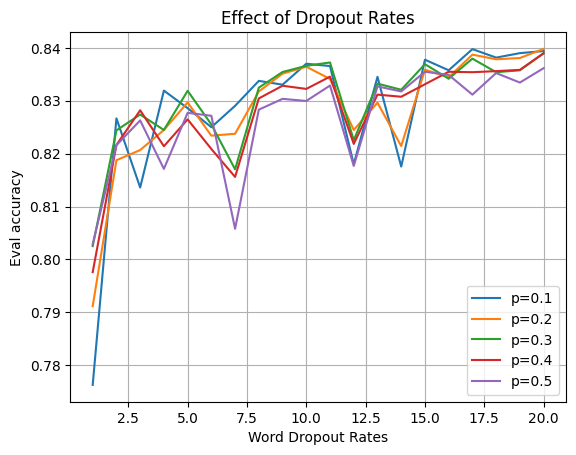

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
for i, result in enumerate(results_B):
  result = list(result)
  plt.plot(np.arange(1, num_epochs + 1), result, label=f"p={drop_rates[i]:.1f}")
plt.xlabel('Word Dropout Rates')
plt.ylabel('Eval accuracy')
plt.title('Effect of Dropout Rates')
plt.grid()
plt.legend()
plt.show()

## SCETION C - Different Layer num

In [41]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

co = DataCollatorWithPadding()
num_epochs = 20
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=num_epochs , #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  eval_strategy="epoch") # Older version might need 'evaluation_strateg' instead

results_C = []
trainers_C = []
for n_layers in range(0,4):
  model = DAN(n_layers=n_layers)
  trainers_C.append(Trainer(
                    model=model,
                    data_collator=co,
                    args=training_args,
                    callbacks = [
                                # YOUR CODE HERE
                                TensorBoardCallback
                                # END YOUR END
                    ],
                    train_dataset=small_train_dataset,
                    eval_dataset=small_eval_dataset,
                    compute_metrics=compute_metrics,
  ))
  trainers_C[-1].train()
  results_C.append(entry["eval_accuracy"] for entry in trainers_C[-1].state.log_history if "eval_accuracy" in entry)

CommError: Run initialization has timed out after 90.0 sec. Please try increasing the timeout with the `init_timeout` setting: `wandb.init(settings=wandb.Settings(init_timeout=120))`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
for i, result in enumerate(results_C):
  plt.plot(np.arange(1, num_epochs + 1), result, label=f"{i} hidden layers")
plt.xlabel('Layer Number')
plt.ylabel('Eval accuracy')
plt.title('Effect of Layer Number')
plt.grid()
plt.legend()
plt.show()

NameError: name 'results_C' is not defined

<Figure size 640x480 with 0 Axes>

## SECTION D - Activations

In [42]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback

co = DataCollatorWithPadding()
num_epochs = 20
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=num_epochs , #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate=0.01,
                                  logging_strategy="epoch",
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  eval_strategy="epoch") # Older version might need 'evaluation_strateg' instead

results_D = []
trainers_D = []
acts = [nn.ReLU(), nn.Tanh(), nn.GELU()]
for acts in acts:
  model = DAN(act=acts)
  trainers_D.append(Trainer(
                    model=model,
                    data_collator=co,
                    args=training_args,
                    callbacks = [
                                # YOUR CODE HERE
                                TensorBoardCallback
                                # END YOUR END
                    ],
                    train_dataset=small_train_dataset,
                    eval_dataset=small_eval_dataset,
                    compute_metrics=compute_metrics,
  ))
  trainers_D[-1].train()
  results_D.append(entry["eval_accuracy"] for entry in trainers_D[-1].state.log_history if "eval_accuracy" in entry)

CommError: Run initialization has timed out after 90.0 sec. Please try increasing the timeout with the `init_timeout` setting: `wandb.init(settings=wandb.Settings(init_timeout=120))`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
for i, result in enumarate(results_D):
    plt.plot(np.arange(1, num_epochs + 1), result, label=f"{acts[i]}")
plt.xlabel('Epoch')
plt.ylabel('Eval accuracy')
plt.title('Effect of Activation Functions')
plt.grid()
plt.legend()
plt.show()

## SECRION E - Sample 5 examples

In [ ]:
# YOUR CODE HERE